**Importation des librairies utilisées**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

**Recueil des images et labels des Training Data puis organisation des  informations dans un Dataframe**

In [ ]:
train_data_dir = '/content/drive/MyDrive/brain-tumor-mri-dataset/Training'
pic_path = []
labels_path = []
folds = os.listdir(train_data_dir)

for i in folds:
    fold_path = os.path.join(train_data_dir, i)
    filelist = os.listdir(fold_path)
    for file in filelist:
        fpath = os.path.join(fold_path, file)

        pic_path.append(fpath) # ajout des images
        labels_path.append(i) # ajout des labels

Fseries = pd.Series(pic_path, name= 'pic_path')
Lseries = pd.Series(labels_path, name='labels_path')
train_df = pd.concat([Fseries, Lseries], axis= 1) # création du dataframe d'entrainement

**Même processus avec les Test Data**

In [ ]:
test_data_dir = '/content/drive/MyDrive/brain-tumor-mri-dataset/Testing'
pic_path = []
labels_path = []
folds = os.listdir(train_data_dir)

for i in folds:
    fold_path = os.path.join(train_data_dir, i)
    filelist = os.listdir(fold_path)
    for file in filelist:
        fpath = os.path.join(fold_path, file)

        pic_path.append(fpath) # ajout des images
        labels_path.append(i) # ajout des labels

Fseries = pd.Series(pic_path, name= 'pic_path')
Lseries = pd.Series(labels_path, name='labels_path')
test_df = pd.concat([Fseries, Lseries], axis= 1) # création du dataframe de test

**Création des dataframes de test et des générateurs de données**

In [ ]:
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, random_state= 43)
# Utilisation d'un random state pour rendre la répartition des données reproductible

batch_size = 16
img_size = (64, 64) # Petite taille d'image pour diminuer la durée d'entrainement

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Création des générateurs de données
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'pic_path', y_col= 'labels_path', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'pic_path', y_col= 'labels_path', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'pic_path', y_col= 'labels_path', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size) # On ne shuffle pas les données pour une bonne reproductibilité

Found 5712 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.


**Affichage des données du dataset**

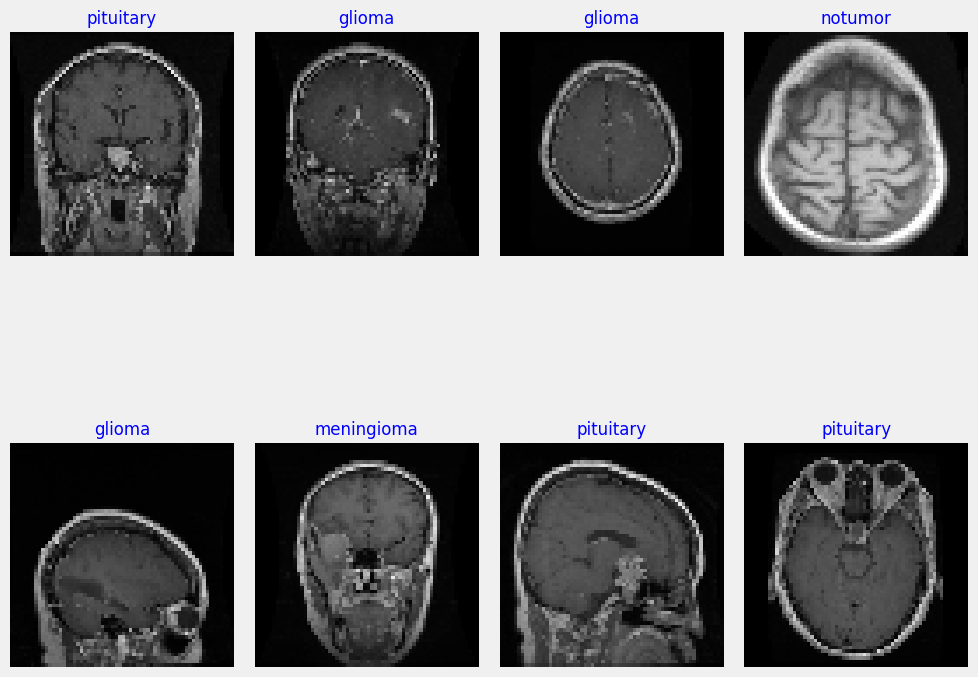

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(10, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


**Construction du modèle**

In [ ]:
# Définition de la taille des images et du nombre de canaux RGB
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

# Création du modèle séquentiel
model = Sequential([

    # Première couche convolutive
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),  # Aplatissement des sorties convolutives 2x2x512 = 2048

    Dense(256,activation = "relu"),
    Dense(class_count, activation = "softmax")  # Couche de sortie avec activation softmax pour la classification finale
])

# Compilation du modèle avec l'optimiseur Adam
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()  # Pour vérifier les dimensions


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,240,260 (58.14 MB)

 Trainable params: 15,240,260 (58.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entraînement du modèle avec train_gen
history = model.fit(
    train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False        # On conserve l'ordre initial des données d'entrainement
)


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1189s 3s/step - accuracy: 0.2611 - loss: 4.8203 - val_accuracy: 0.2822 - val_loss: 1.3836
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.2708 - loss: 1.3855 - val_accuracy: 0.2822 - val_loss: 1.3831
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - accuracy: 0.2745 - loss: 1.3847 - val_accuracy: 0.2822 - val_loss: 1.3831
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.2866 - loss: 1.3824 - val_accuracy: 0.2822 - val_loss: 1.3832
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.2886 - loss: 1.3828 - val_accuracy: 0.2822 - val_loss: 1.3833
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.2703 - loss: 1.3852 - val_accuracy: 0.2822 - val_loss: 1.3831
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.2737 - loss: 1.3851 - val_accuracy: 0.2822 - val_loss: 1.3832
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step - accuracy: 0.2885 - loss: 1.

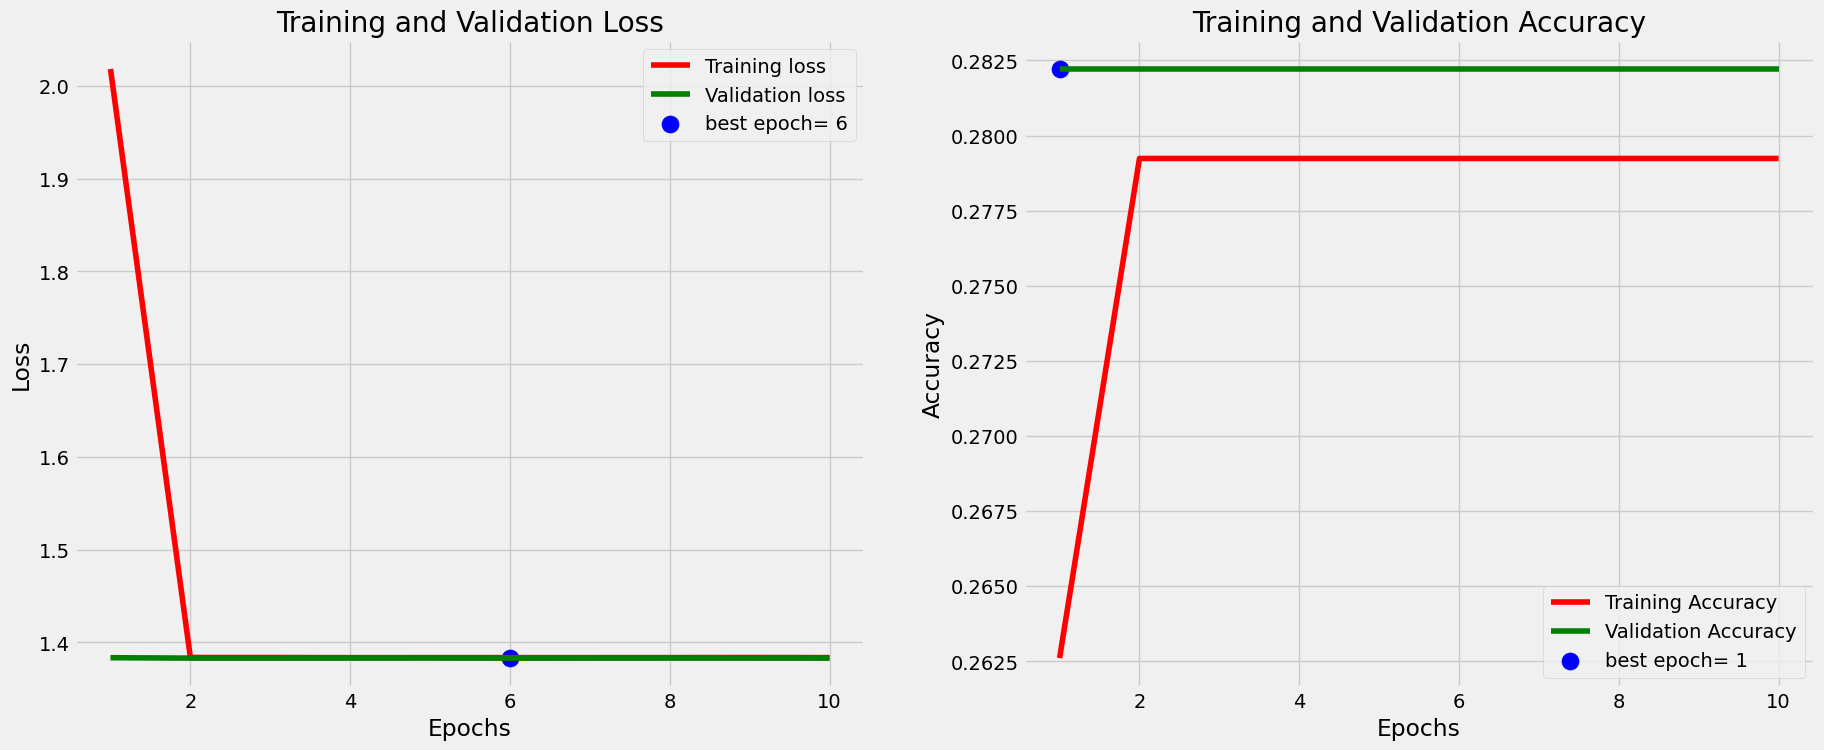

In [ ]:
# Extraction des métriques d'entrainement
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Identification de l'epoch avec la loss minimale
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

# Identification de l'epoch avec l'accuracy maximale
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Setup des données pour le tracé des courbes
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# Tracé de la courbe loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracé de la courbe accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

**Evaluation du modèle**

In [ ]:
# Evaluation des performances sur les données d'entrainement de validation et de test
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

# Affichage des résultats
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("\n")
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("\n")
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.2791 - loss: 1.3834
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.2936 - loss: 1.3815
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.2824 - loss: 1.3829
Train Loss:  1.38350510597229
Train Accuracy:  0.27923670411109924


Validation Loss:  1.3831337690353394
Validation Accuracy:  0.28221288323402405


Test Loss:  1.383875846862793
Test Accuracy:  0.27626049518585205


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

print(classification_report(test_gen.classes, y_pred, target_names= classes))

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       328
  meningioma       0.00      0.00      0.00       344
     notumor       0.28      1.00      0.44       397
   pituitary       0.00      0.00      0.00       359

    accuracy                           0.28      1428
   macro avg       0.07      0.25      0.11      1428
weighted avg       0.08      0.28      0.12      1428



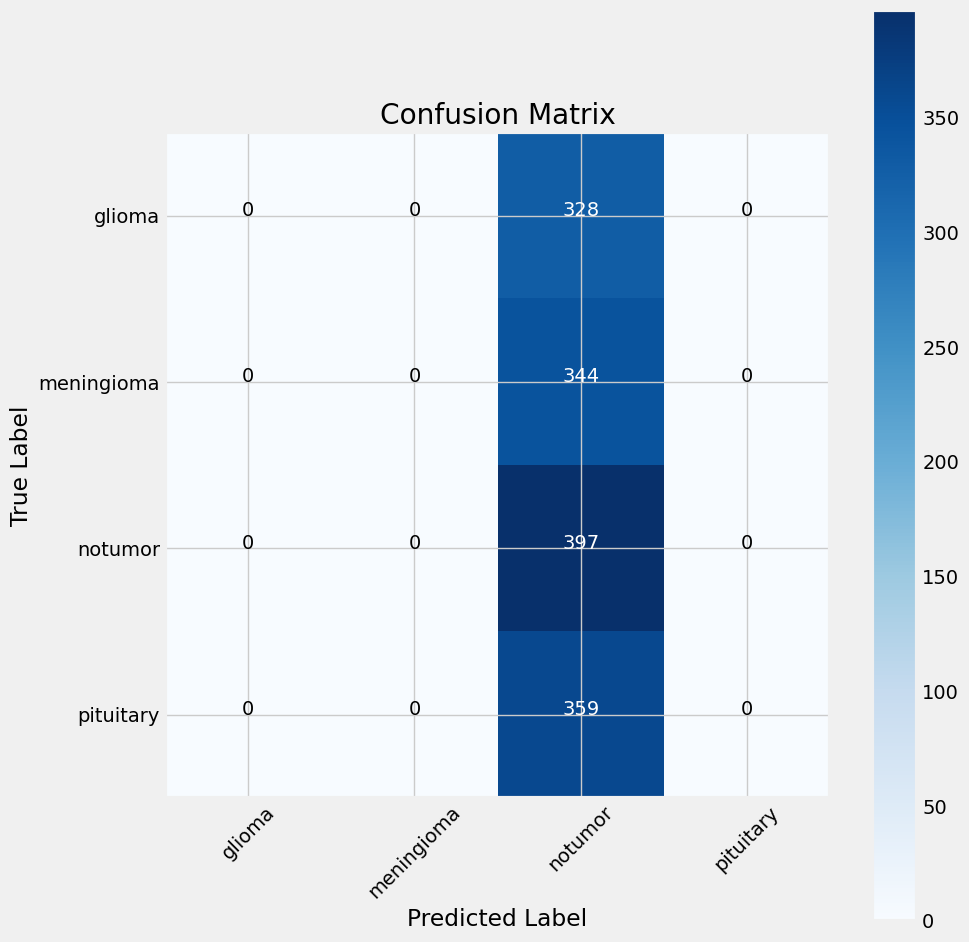

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Matrice de confusion
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()